In [1]:
from fastai.tabular import *
from fastai.callbacks import SaveModelCallback

In [16]:
# def auroc_score(input, target):
#     input, target = input.cpu().numpy()[:,1], target.cpu().numpy()
#     return roc_auc_score(target, input)

# class AUROC(Callback):
#     _order = -20 #Needs to run before the recorder

#     def __init__(self, learn, **kwargs): self.learn = learn
#     def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['AUROC'])
#     def on_epoch_begin(self, **kwargs): self.output, self.target = [], []
    
#     def on_batch_end(self, last_target, last_output, train, **kwargs):
#         if not train:
#             self.output.append(last_output)
#             self.target.append(last_target)
                
#     def on_epoch_end(self, last_target, last_output, **kwargs):
#         if len(self.output) > 0:
#             output = torch.cat(self.output)
#             target = torch.cat(self.target)
#             preds = F.softmax(output, dim=1)
#             metric = auroc_score(preds, target)
#             self.learn.recorder.add_metrics([metric])


In [4]:
import pandas as pd
import numpy as np
import gc

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split, ShuffleSplit, StratifiedKFold

pd.set_option('display.max_columns', None)

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe:         
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

def make_real_feature(df, name, group_col='userid'):
    """
    вычисление разных статистик
    """
    tmp = df.groupby(group_col)[name].agg({np.mean, max, min, np.median, sum, np.var}).fillna(-1)
    tmp.columns = [name + '_' + str(x) for x in tmp.columns]
    tmp = tmp.reset_index()
    return (tmp[tmp.columns[tmp.nunique()>1]])

def make_harmonic_features(df, column):
    for col in column:
        period = df[col].nunique()
        value = df[col].copy()
        value *= 2 * np.pi / period
        df[col + '_cos'] = np.cos(value)
        df[col + '_sin'] = np.sin(value)
    return (df)

In [5]:
df_train = pd.read_csv('onetwotrip_challenge_train.csv')
df = downcast_dtypes(df_train)
del df_train
gc.collect()

cols_to_rename = {'field0': 'days_from_last',
                 'field2': 'month_buy',
                 'field3': 'month_depart',
                 'field4': 'order_of_buy',
                 'field9': 'ticket_child_1y',
                 'field11': 'hour_depart',
                 'field15': 'total_tickets',
                 'field16': 'days_before_depart',
                 'field18': 'dow_buy',
                 'field20': 'dow_depart',
                 'field21': 'year',
                 'field24': 'ticket_adult',
                 'field28': 'ticket_child_4y',
                 'field29': 'quarter'};

df.rename(columns=cols_to_rename, inplace=True)

In [6]:
df['unq'] = df.userid.map(df.groupby('userid').size())
df['order_of_buy_invert'] = df.unq-df.order_of_buy

df['diff_month'] = (df.month_depart - df.month_buy)
df['diff_hour'] = df.field23 - df.hour_depart

In [ ]:
# make real feats

# dfl = make_real_feature(df, name='days_from_last')
# f1 = make_real_feature(df, name='field1')
# f14 = make_real_feature(df, name='field14')




In [7]:
# periodical_feats

periodical_feats = ['month_buy', 'month_depart', 
                    'hour_depart', 'dow_buy', 'dow_depart', 'quarter', 'field27', 'field23']

df_new = make_harmonic_features(df, periodical_feats).copy()

In [6]:
df_new.drop(columns=periodical_feats, axis=1, inplace=True)
df_new.shape

(196056, 55)

In [8]:
to_drop = ['orderid', 'userid', 'goal21', 'goal22', 'goal23', 'goal24', 'goal25']
df_new.drop(columns=to_drop, axis=1, inplace=True)
df_new.shape

(196056, 56)

In [9]:
train, test = train_test_split(df_new, stratify=df_new.goal1, random_state=17)

In [12]:
drop_col_test = ['goal1']
y_test = test.goal1.copy()
X_test = test.drop(columns=drop_col_test, axis=1)

In [9]:
cols_cos_sin = list(filter(lambda x: ('cos' in x) | ('sin' in x) , df_new.columns))

procs = [Categorify, Normalize]
cat_names = ['field5', 'field7', 'field8','field10', 'field19', 'year', 'indicator_goal21', 
             'indicator_goal22', 'indicator_goal23', 'indicator_goal24', 'indicator_goal25']

cont_names = ['days_from_last', 'order_of_buy', 'field1', 'field6', 'field12', 'field13', 'field14', 
              'total_tickets', 'days_before_depart', 'field17', 'field22', 'field25', 'field26', 
              'ticket_child_4y', 'ticket_child_1y', 'ticket_adult', 'unq', 'order_of_buy_invert',
              'diff_month', 'diff_hour'] + cols_cos_sin

dep_var = 'goal1'

In [13]:
data = (TabularList.from_df(train, procs=procs, cont_names=cont_names, cat_names=cat_names)
        .split_by_idx(valid_idx=range(int(len(train)*0.85),len(train)))
        .label_from_df(cols=dep_var)
        .add_test(TabularList.from_df(X_test, cat_names=cat_names, cont_names=cont_names, procs=procs))
        .databunch())
print(data.train_ds.cont_names)
print(data.train_ds.cat_names)

['days_from_last', 'order_of_buy', 'field1', 'field6', 'field12', 'field13', 'field14', 'total_tickets', 'days_before_depart', 'field17', 'field22', 'field25', 'field26', 'ticket_child_4y', 'ticket_child_1y', 'ticket_adult', 'unq', 'order_of_buy_invert', 'diff_month', 'diff_hour', 'month_buy_cos', 'month_buy_sin', 'month_depart_cos', 'month_depart_sin', 'hour_depart_cos', 'hour_depart_sin', 'dow_buy_cos', 'dow_buy_sin', 'dow_depart_cos', 'dow_depart_sin', 'quarter_cos', 'quarter_sin', 'field27_cos', 'field27_sin', 'field23_cos', 'field23_sin']
['field5', 'field7', 'field8', 'field10', 'field19', 'year', 'indicator_goal21', 'indicator_goal22', 'indicator_goal23', 'indicator_goal24', 'indicator_goal25']


In [14]:
len(data.test_ds.cont_names),len(data.test_ds.cat_names)

(36, 11)

In [39]:
learn = tabular_learner(data, layers=[1000,500], metrics=[dice], 
                        callback_fns=[ShowGraph, SaveModelCallback])


In [112]:
# pd.merge(df, tmp, how='left', on=['userid'])

In [ ]:
learn.fit_one_cycle(5, 2.5e-2)

epoch,train_loss,valid_loss,dice,time


In [ ]:
learn.lr_find()
learn.recorder.plot()

In [35]:
def auc_score(y_score, y_true):
    return torch.tensor(roc_auc_score(y_true,y_score[:,1]))
probs,val_labels = learn.get_preds(ds_type=DatasetType.Valid) 
# print('Error Rate', error_rate(probs, val_labels))
print('AUC', auc_score(probs,val_labels))

AUC tensor(0.4193)


In [36]:
probs,val_labels = learn.get_preds(ds_type=DatasetType.Valid) # Predicting without TTA
auc_score(probs,val_labels)

tensor(0.4193)

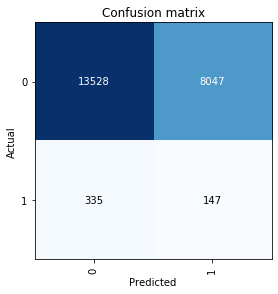

In [38]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(title='Confusion matrix')

In [10]:
train

,days_from_last,field1,month_buy,month_depart,order_of_buy,field5,field6,field7,field8,ticket_child_1y,field10,hour_depart,field12,field13,field14,total_tickets,days_before_depart,field17,dow_buy,field19,dow_depart,year,field22,field23,ticket_adult,field25,field26,field27,ticket_child_4y,quarter,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,goal1,unq,order_of_buy_invert,diff_month,diff_hour,month_buy_cos,month_buy_sin,month_depart_cos,month_depart_sin,hour_depart_cos,hour_depart_sin,dow_buy_cos,dow_buy_sin,dow_depart_cos,dow_depart_sin,quarter_cos,quarter_sin,field27_cos,field27_sin,field23_cos,field23_sin
184515,0,-0.083509,7,7,1,1,0,1,1,0,0,17,5,3,0.319156,1,2,1,5,2,7,1,9,18,1,1,3,1,0,3,1,1,0,0,1,0,2,1,0,1,-0.866025,-5.000000e-01,-8.660254e-01,-5.000000e-01,-2.588190e-01,-9.659258e-01,-0.222521,-9.749279e-01,1.000000,-2.449294e-16,-1.836970e-16,-1.000000e+00,0.623490,0.781831,-1.836970e-16,-1.000000
76833,0,0.149205,7,8,1,1,0,1,1,0,1,0,4,2,-0.241109,2,57,1,3,2,3,1,1,21,2,1,3,1,0,3,1,1,0,1,1,0,1,0,1,21,-0.866025,-5.000000e-01,-5.000000e-01,-8.660254e-01,1.000000e+00,0.000000e+00,-0.900969,4.338837e-01,-0.900969,4.338837e-01,-1.836970e-16,-1.000000e+00,0.623490,0.781831,7.071068e-01,-0.707107
38145,0,-0.083509,6,7,1,1,0,1,1,1,0,9,19,63,0.179090,2,17,1,5,1,1,1,20,9,1,1,1,1,0,2,1,1,1,1,0,0,1,0,1,0,-1.000000,1.224647e-16,-8.660254e-01,-5.000000e-01,-7.071068e-01,7.071068e-01,-0.222521,-9.749279e-01,0.623490,7.818315e-01,-1.000000e+00,1.224647e-16,0.623490,0.781831,-7.071068e-01,0.707107
118724,0,-0.316223,6,7,1,1,0,1,1,0,0,18,19,4,-0.101043,1,24,1,6,1,2,1,21,10,1,1,1,1,0,2,1,1,0,1,1,0,1,0,1,-8,-1.000000,1.224647e-16,-8.660254e-01,-5.000000e-01,-1.836970e-16,-1.000000e+00,0.623490,-7.818315e-01,-0.222521,9.749279e-01,-1.000000e+00,1.224647e-16,0.623490,0.781831,-8.660254e-01,0.500000
159503,3,-0.393794,8,9,3,0,0,1,1,0,0,11,5,26,-0.241109,1,5,1,3,2,1,1,1,3,1,1,3,1,0,3,1,1,0,1,1,0,3,0,1,-8,-0.500000,-8.660254e-01,-1.836970e-16,-1.000000e+00,-9.659258e-01,2.588190e-01,-0.900969,4.338837e-01,0.623490,7.818315e-01,-1.836970e-16,-1.000000e+00,0.623490,0.781831,7.071068e-01,0.707107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131171,0,0.226777,6,9,1,1,4,1,1,0,1,12,4,31,-0.241109,2,83,1,4,1,3,1,1,8,2,1,3,1,0,2,1,1,0,1,1,0,1,0,3,-4,-1.000000,1.224647e-16,-1.836970e-16,-1.000000e+00,-1.000000e+00,1.224647e-16,-0.900969,-4.338837e-01,-0.900969,4.338837e-01,-1.000000e+00,1.224647e-16,0.623490,0.781831,-5.000000e-01,0.866025
120693,3,-0.393794,12,12,3,0,0,1,1,1,0,23,3,3,-0.661308,3,2,1,7,3,2,1,31,17,2,1,1,1,0,4,1,1,0,0,0,0,7,4,0,-6,1.000000,-2.449294e-16,1.000000e+00,-2.449294e-16,9.659258e-01,-2.588190e-01,1.000000,-2.449294e-16,-0.222521,9.749279e-01,1.000000e+00,-2.449294e-16,0.623490,0.781831,-2.588190e-01,-0.965926
44626,0,0.692205,8,10,2,0,0,2,1,0,1,14,136,505,-0.101043,3,73,68,4,2,7,1,437,8,3,81,12,3,0,3,1,1,0,0,0,0,2,0,2,-6,-0.500000,-8.660254e-01,5.000000e-01,-8.660254e-01,-8.660254e-01,-5.000000e-01,-0.900969,-4.338837e-01,1.000000,-2.449294e-16,-1.836970e-16,-1.000000e+00,-0.900969,0.433884,-5.000000e-01,0.866025
83337,5,-0.471365,6,6,4,0,0,1,1,0,1,16,4,3,-0.381176,1,8,1,6,3,7,2,8,8,1,1,5,3,0,2,1,1,0,1,1,0,9,5,0,-8,-1.000000,1.224647e-16,-1.000000e+00,1.224647e-16,-5.000000e-01,-8.660254e-01,0.623490,-7.818315e-01,1.000000,-2.449294e-16,-1.000000e+00,1.224647e-16,-0.900969,0.433884,-5.000000e-01,0.866025


In [1]:
from featexp import get_univariate_plots

In [14]:
train.columns

Index(['days_from_last', 'field1', 'month_buy', 'month_depart', 'order_of_buy',
       'field5', 'field6', 'field7', 'field8', 'ticket_child_1y', 'field10',
       'hour_depart', 'field12', 'field13', 'field14', 'total_tickets',
       'days_before_depart', 'field17', 'dow_buy', 'field19', 'dow_depart',
       'year', 'field22', 'field23', 'ticket_adult', 'field25', 'field26',
       'field27', 'ticket_child_4y', 'quarter', 'indicator_goal21',
       'indicator_goal22', 'indicator_goal23', 'indicator_goal24',
       'indicator_goal25', 'goal1', 'unq', 'order_of_buy_invert', 'diff_month',
       'diff_hour', 'month_buy_cos', 'month_buy_sin', 'month_depart_cos',
       'month_depart_sin', 'hour_depart_cos', 'hour_depart_sin', 'dow_buy_cos',
       'dow_buy_sin', 'dow_depart_cos', 'dow_depart_sin', 'quarter_cos',
       'quarter_sin', 'field27_cos', 'field27_sin', 'field23_cos',
       'field23_sin'],
      dtype='object')

                                            Plots for unq                                             
                                           Train data plots                                           


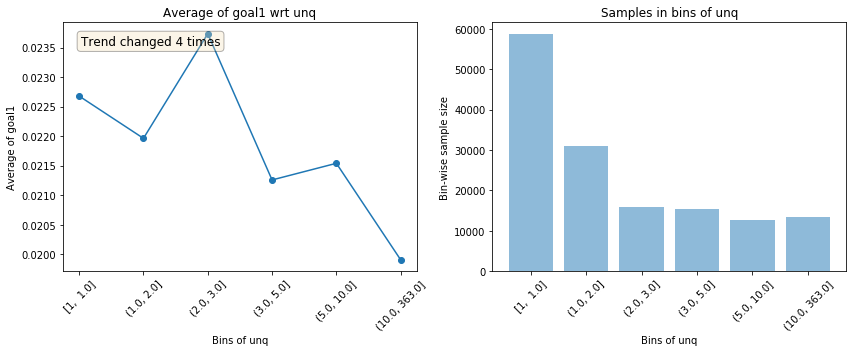

                                           Test data plots                                            


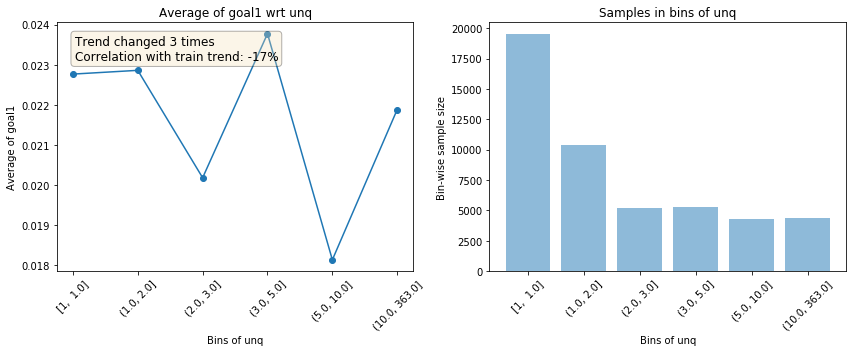

--------------------------------------------------------------------------------------------------------------




In [20]:
get_univariate_plots(data=train, target_col='goal1', 
                     data_test=test, features_list=['unq'])

                                          Plots for field12                                           
                                           Train data plots                                           


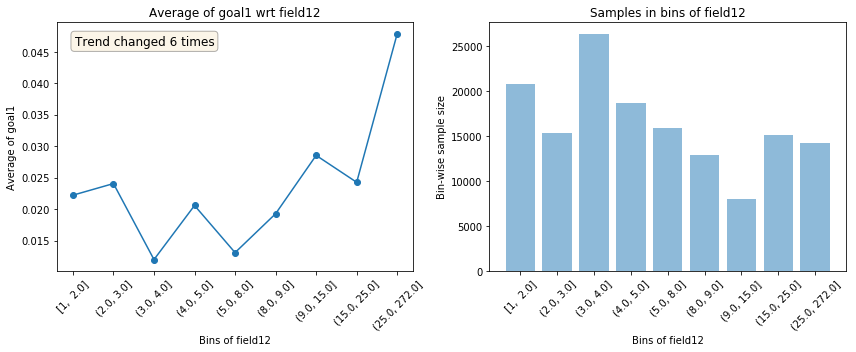

                                           Test data plots                                            


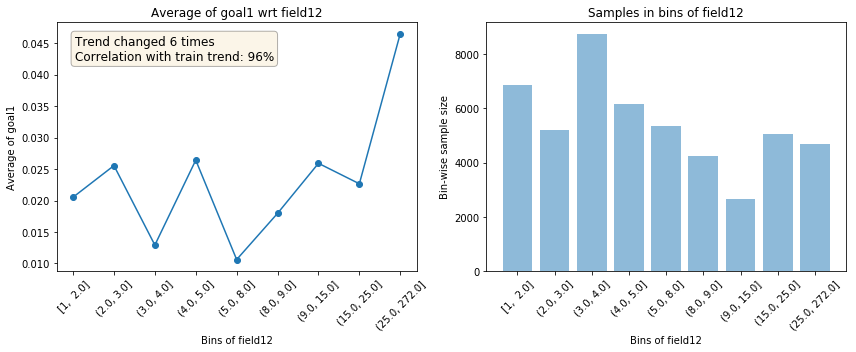

--------------------------------------------------------------------------------------------------------------


                                          Plots for field12                                           


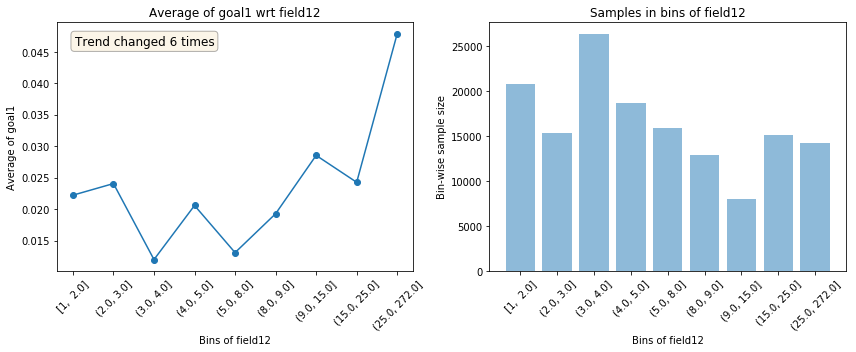

--------------------------------------------------------------------------------------------------------------




In [21]:
from featexp import univariate_plotter

binned_data_train, binned_data_test = univariate_plotter(data=train, target_col='goal1', 
                                                         feature='field12', data_test=test)
# For only train data
binned_data_train = univariate_plotter(data=train, target_col='goal1', feature='field12')

In [22]:
binned_data_train

,field12,Samples_in_bin,goal1_mean,field12_mean
0,"[1, 2.0]",20804,0.022207,1.649058
1,"(2.0, 3.0]",15301,0.024051,3.000000
2,"(3.0, 4.0]",26296,0.011979,4.000000
3,"(4.0, 5.0]",18620,0.020569,5.000000
4,"(5.0, 8.0]",15898,0.013083,7.943515
5,"(8.0, 9.0]",12876,0.019261,9.000000
6,"(9.0, 15.0]",7992,0.028529,12.625626
7,"(15.0, 25.0]",15089,0.024256,20.235337
8,"(25.0, 272.0]",14166,0.047861,59.109558


In [23]:
from featexp import get_trend_stats

stats = get_trend_stats(data=train, target_col='goal1', data_test=test)

# data_test is optional. If not passed, trend correlations aren't calculated.
stats

Only one bin created for indicator_goal21. Correlation can't be calculated
Only one bin created for indicator_goal22. Correlation can't be calculated
Returning stats for all numeric features


,Feature,Trend_changes,Trend_changes_test,Trend_correlation
0,days_from_last,2,2,0.850982
1,field1,0,5,0.934341
2,month_buy,3,5,0.820835
3,month_depart,3,3,0.356626
4,order_of_buy,2,1,0.790927
5,field5,0,0,1.000000
6,field6,2,0,0.938999
7,field7,0,0,1.000000
8,field8,0,0,1.000000
9,ticket_child_1y,0,0,-1.000000


In [27]:
test.columns

Index(['days_from_last', 'field1', 'month_buy', 'month_depart', 'order_of_buy',
       'field5', 'field6', 'field7', 'field8', 'ticket_child_1y', 'field10',
       'hour_depart', 'field12', 'field13', 'field14', 'total_tickets',
       'days_before_depart', 'field17', 'dow_buy', 'field19', 'dow_depart',
       'year', 'field22', 'field23', 'ticket_adult', 'field25', 'field26',
       'field27', 'ticket_child_4y', 'quarter', 'indicator_goal21',
       'indicator_goal22', 'indicator_goal23', 'indicator_goal24',
       'indicator_goal25', 'goal1', 'unq', 'order_of_buy_invert', 'diff_month',
       'diff_hour', 'month_buy_cos', 'month_buy_sin', 'month_depart_cos',
       'month_depart_sin', 'hour_depart_cos', 'hour_depart_sin', 'dow_buy_cos',
       'dow_buy_sin', 'dow_depart_cos', 'dow_depart_sin', 'quarter_cos',
       'quarter_sin', 'field27_cos', 'field27_sin', 'field23_cos',
       'field23_sin'],
      dtype='object')

In [31]:
X=test.iloc[:, np.r_[:30, 37:40]].copy

,days_from_last,field1,month_buy,month_depart,order_of_buy,field5,field6,field7,field8,ticket_child_1y,field10,hour_depart,field12,field13,field14,total_tickets,days_before_depart,field17,dow_buy,field19,dow_depart,year,field22,field23,ticket_adult,field25,field26,field27,ticket_child_4y,quarter,order_of_buy_invert,diff_month,diff_hour
72830,10,-0.548937,3,4,5,0,4,1,0,0,1,14,4,3,-0.381176,1,26,1,4,3,2,2,40,20,1,1,5,3,0,1,3,1,6
36073,0,-0.471365,8,9,1,1,0,1,1,0,1,11,8,20,-0.381176,1,29,1,5,3,6,1,1,6,1,1,1,1,0,3,0,1,-5
50178,1,0.381920,7,7,3,0,0,1,1,0,0,13,8,5,0.039024,2,1,1,6,3,7,1,1,6,2,1,5,3,0,3,3,0,-7
68830,0,-0.005937,10,10,1,1,12,1,0,0,1,19,4,4,0.319156,1,26,1,1,3,6,1,82,18,1,1,3,1,0,4,0,0,-1
25638,0,7.130628,11,4,1,1,17,2,0,0,1,1,128,3,6.201945,2,147,1,4,4,3,1,107,18,2,36,3,1,0,4,0,-7,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181417,0,0.304348,6,6,1,1,0,2,1,0,1,0,2,6,0.179090,2,7,1,7,1,6,1,27,23,1,10,1,1,1,2,0,0,23
121185,0,0.304348,8,9,1,1,7,1,1,0,1,23,8,3,-0.521242,4,27,1,3,3,2,1,16,19,4,1,1,1,0,3,0,1,-4
125690,0,-0.626508,11,12,1,1,0,1,1,0,0,13,23,26,-0.661308,1,8,1,6,2,7,1,106,22,1,1,12,3,0,4,1,1,9
131549,13,-0.626508,2,3,4,0,0,1,1,0,1,20,4,23,-0.801375,1,37,1,3,2,5,2,20,17,1,1,12,3,0,1,21,1,-3


In [45]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [36]:
X=test.iloc[:, np.r_[:30, 37:40]].copy()

In [40]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [42]:
tsne = TSNE(random_state=17)
tsne_repr = tsne.fit_transform(X_scaled)

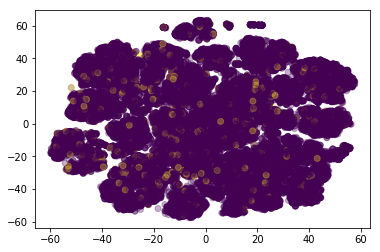

In [58]:
plt.scatter(tsne_repr[:, 0], tsne_repr[:, 1], c=test['goal1'], alpha=.3);

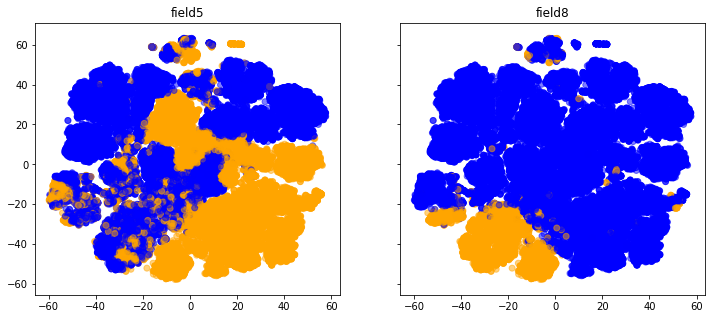

In [57]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 5))

for i, name in enumerate(['field5', 'field8']):
    axes[i].scatter(tsne_repr[:, 0], tsne_repr[:, 1], 
                    c=test[name].map({0: 'orange', 1: 'blue'}), alpha=.5);
    axes[i].set_title(name);

In [ ]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 5))

for i, name in enumerate(['International plan', 'Voice mail plan']):
    axes[i].scatter(tsne_repr[:, 0], tsne_repr[:, 1], 
                    c=df[name].map({'Yes': 'orange', 'No': 'blue'}), alpha=.5);
    axes[i].set_title(name);

In [61]:
tsne_repr

array([[ -8.561132 , -53.678852 ],
       [ 38.415092 ,  32.54059  ],
       [ -3.457482 ,  12.288159 ],
       ...,
       [  5.6737695,  18.840654 ],
       [ 43.11138  , -21.371368 ],
       [  2.6774385,  41.914402 ]], dtype=float32)